## Loading the packages

In [86]:
import numpy as np
import matplotlib.pyplot as pl
import sys

import pandas as pd
from ipywidgets import interact, widgets
import os

%matplotlib inline

In [87]:
PATH = '../vowels'

from python_speech_features import mfcc
import scipy.io.wavfile as wav

import glob
nam_paths = glob.glob(os.path.join(PATH, 'nam*.wav'))
naf_paths = glob.glob(os.path.join(PATH, 'naf*.wav'))
nk_paths = glob.glob(os.path.join(PATH, 'nk*.wav'))

# Imports Dataset

In [88]:
# Here we read the wave files and store their content in lists
naf_audios = [wav.read(path) for path in naf_paths]
nam_audios = [wav.read(path) for path in nam_paths]

# Analyze Data and normalization

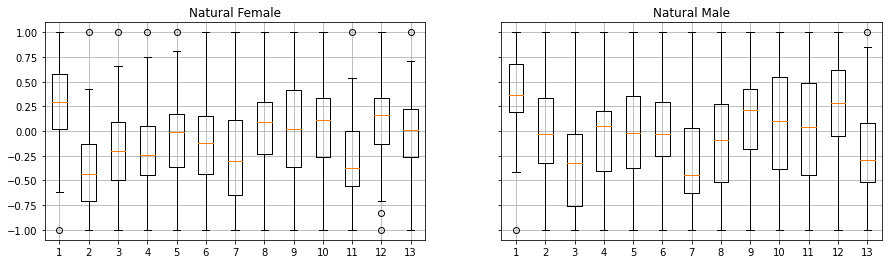

In [89]:
from sklearn import preprocessing

naf_mfcc_median = np.array([np.median(mfcc(naf[1], naf[0], nfft=1024), axis=0) for naf in naf_audios])# ...
nam_mfcc_median = np.array([np.median(mfcc(nam[1], nam[0], nfft=1024), axis=0) for nam in nam_audios])# ...

# Normalize the data attributes

minMaxScaler = preprocessing.MinMaxScaler()
naf_mfcc_median= 2 * minMaxScaler.fit_transform(naf_mfcc_median) - 1
nam_mfcc_median= 2 * minMaxScaler.fit_transform(nam_mfcc_median) - 1

f, (ax1, ax2) = pl.subplots(1,2, sharey='all', figsize=(15,4))
ax1.plot()
ax1.boxplot(naf_mfcc_median)
ax1.set_title('Natural Female')
ax1.grid()
ax2.boxplot(nam_mfcc_median)
ax2.set_title('Natural Male')
ax2.grid()

On a trouvé que les paires de MFCC (8,9), (8,4), (9,4) pourraient être utiles pour la prédiction. Mais pour cette expérience, on peut simplement utiliser l'ensemble complet des MFCC.

# MLP

## Exploring the number of epochs and hyper parameters

In [90]:
import mlp_backprop_momentum as mlp
import k_fold_cross_validation as cv

mfccs = np.concatenate((
    naf_mfcc_median,
    nam_mfcc_median
))

# We use -1 and 1 for classes because we use the tanh function
classes = np.concatenate(
    (
        np.append(naf_mfcc_median, [[1]] * len(naf_mfcc_median), axis=1),
        np.append(nam_mfcc_median, [[-1]] * len(nam_mfcc_median), axis=1)
    )
)
print(mfccs)
print(classes)

df_mfcc = np.append(mfccs, classes, axis=1)
# Hyper parameters...
N_INITS = 10
EPOCHS = 100
N_NEURONS = [1, 4, 8, 10]
LEARNING_RATE = 0.001
MOMENTUM = 0.8

[[ 3.35152941e-01  2.49509963e-01 -4.83103943e-01 -5.27638862e-01
  -2.66006448e-01  1.97893569e-01  5.66202126e-01  1.00000000e+00
  -2.12125401e-01 -8.66286571e-01  5.34871061e-01 -4.45463911e-01
  -5.21444518e-01]
 [ 7.94538643e-01 -4.64739079e-01 -4.92055169e-01  2.85139743e-02
  -3.41247373e-01  1.15586816e-01 -6.30809496e-01  7.20489847e-01
   9.82684697e-01  2.33106320e-01 -6.63080077e-01 -7.05420655e-01
  -3.46806642e-01]
 [ 8.84786919e-01  2.40430502e-01 -3.91694982e-01 -5.31826335e-01
  -1.00000000e+00 -1.15001076e-01  1.00000000e+00  6.20542876e-01
  -3.90183283e-01  1.94141282e-01 -4.30252003e-01 -5.54398150e-02
  -1.30367336e-02]
 [ 2.50014149e-01 -7.48097320e-01 -8.62003701e-02  4.48492796e-01
   1.46267500e-01 -3.08237476e-01 -9.57652799e-01  1.57157465e-01
   4.09033539e-01 -7.57005963e-01 -3.70447182e-01  4.08233472e-01
   3.37789735e-01]
 [ 1.00000000e+00 -7.05476036e-01 -6.86394962e-01  2.97485795e-01
  -1.79648468e-01 -4.13335526e-01 -9.04353651e-01  1.46972020e-01


In [91]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_INITS):                                        # looping over the initializations
        nn.init_weights()

#        MSE[i_h, i, :] = nn.fit((df_mfcc.loc[:, df_mfcc.columns != 'class'], df_mfcc['class']),
        MSE[i_h, i, :] = nn.fit((df_mfcc[:,0:13], df_mfcc[:,13:14]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 10 neurons...


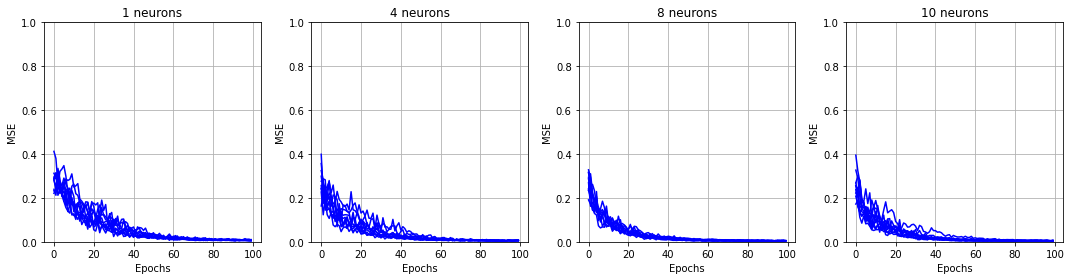

In [92]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

On peut voir que l'erreur ne diminue pas de manière significative après ~40 Epochs.
Un learning rate de 0.001 et un momentum de 0.5 donne des résultats qui semblent acceptables. Nous les utiliserons comme base.

## Exploring the number of hidden neurons

In [93]:
K = 5
N_TESTS = 10

N_INITS = 10
EPOCHS = 100
N_NEURONS = [1, 4]
LEARNING_RATE = 0.2
MOMENTUM = 0.7

In [94]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            df_mfcc,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2

Testing 1 neurons...
Testing 4 neurons...


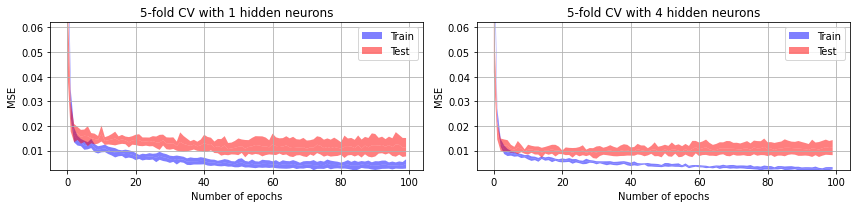

In [95]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.5*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

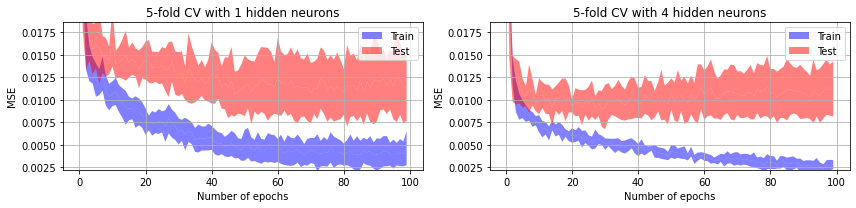

In [96]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.15*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

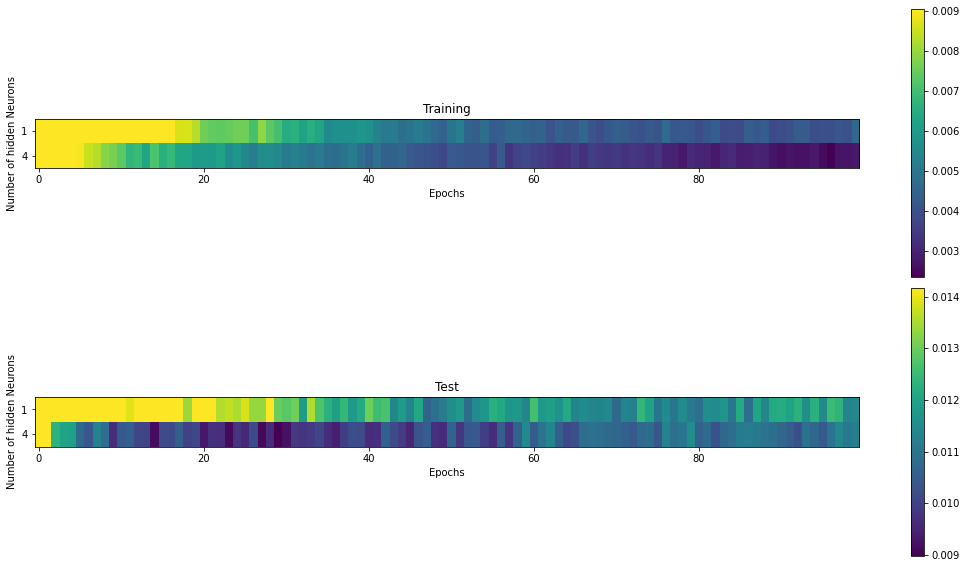

In [97]:
pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

Après de nombreux tests avec differents sets d'hyper-paramètre nous avons trouvé de meilleures performances avec un nombre faible de neurones (<4), mais un learning rate élevé (entre 0.1 et 0.2).

## Final model

Notre modèle final aura donc 4 neurones, 0.2 de learning rate, un momentum de 0.7 et 40 epochs

In [98]:
nn = mlp.MLP([13,4,1], 'tanh')

EPOCHS = 40
LEARNING_RATE = 0.2
MOMENTUM = 0.7

THRESHOLD = 0.0

In [99]:
def k_fold_cross_validation_without_matrix(mlp, dataset, k=5, learning_rate=0.01, momentum=0.7, epochs=100, threshold=None):
    MSE_train_mean = 0.0
    MSE_test_mean = 0.0

    parts = cv.split_dataset(dataset, k)
    print(parts)
    target_test = []
    output_test = []

    for k_i in np.arange(k):
        mlp.init_weights()

        training_parts = set(np.arange(k))
        training_parts.remove(k_i)
        dataset_train = np.concatenate([parts[i] for i in list(training_parts)])
        dataset_test = parts[k_i]

        input_data = dataset_train[:,0:mlp.n_inputs]
        output_data = dataset_train[:,mlp.n_inputs:(mlp.n_inputs+mlp.n_outputs)]
        input_data_test = dataset_test[:,0:mlp.n_inputs]
        output_data_test = dataset_test[:,mlp.n_inputs:(mlp.n_inputs+mlp.n_outputs)]

        mlp.fit((input_data, output_data),
                learning_rate=learning_rate, momentum=momentum, epochs=epochs)
        MSE_train, _ = mlp.compute_MSE((input_data, output_data))
        MSE_train_mean += MSE_train

        MSE_test, temp_out = mlp.compute_MSE((input_data_test, output_data_test))
        MSE_test_mean += MSE_test
        output_test.append(temp_out)
        target_test.append(output_data_test)

    target_test = np.concatenate(target_test, axis=0)
    output_test = np.concatenate(output_test, axis=0)

    if threshold is None:
        return (MSE_train_mean / k, MSE_test_mean / k)
    else:
        return (MSE_train_mean / k, MSE_test_mean / k, target_test, output_test)

In [100]:
N_SPLITS = 10

MSE_train = np.zeros(N_SPLITS)
MSE_test = np.zeros(N_SPLITS)

targets = []
outputs = []

for d in np.arange(N_SPLITS):
    sys.stdout.write('.')
    temp1, temp2, target, output = k_fold_cross_validation_without_matrix(nn,
                                                              df_mfcc,
                                                              k=K,
                                                              learning_rate=LEARNING_RATE,
                                                              momentum=MOMENTUM,
                                                              epochs=EPOCHS,
                                                              threshold=THRESHOLD)

    MSE_train[d] = temp1
    MSE_test[d] = temp2
    targets.append(target)
    outputs.append(output)

targets = np.concatenate(targets, axis=0)
outputs = np.concatenate(outputs, axis=0)

.[array([[ 1.        , -0.71913487, -0.5323986 ,  0.14195591,  0.87917215,
        -0.25967591, -0.71546087, -0.08609301,  0.33183628,  0.38238543,
        -0.46836569, -0.07701414,  0.3163399 ,  1.        , -0.71913487,
        -0.5323986 ,  0.14195591,  0.87917215, -0.25967591, -0.71546087,
        -0.08609301,  0.33183628,  0.38238543, -0.46836569, -0.07701414,
         0.3163399 , -1.        ],
       [-0.40976106,  0.66088692,  0.28164341,  0.03089056, -1.        ,
         0.29047177, -0.53803623,  0.5163027 , -0.10055328, -0.65394635,
        -0.07749568, -0.42461227,  1.        , -0.40976106,  0.66088692,
         0.28164341,  0.03089056, -1.        ,  0.29047177, -0.53803623,
         0.5163027 , -0.10055328, -0.65394635, -0.07749568, -0.42461227,
         1.        , -1.        ],
       [ 0.91892659, -0.68645841, -0.17944368,  0.06832891,  0.60243857,
        -0.59098008, -0.95947557,  0.15271492,  0.21759436,  0.274712  ,
         0.07370219,  0.18455848, -0.08573983,  0.91

In [101]:
conf_mat = cv.compute_confusion_matrix(targets, outputs, THRESHOLD)

y_pred = [-1 if y[0] < THRESHOLD else 1 for y in outputs.tolist()]
y_true = [-1 if y[0] < THRESHOLD else 1 for y in targets.tolist()]

In [102]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  [0.00313593 0.0042213  0.00271025 0.00377349 0.00332525 0.00391341
 0.00326531 0.0023586  0.00212991 0.00243765]
MSE test:  [0.00911656 0.00827095 0.00831877 0.01272098 0.01291621 0.01011335
 0.00751792 0.00474417 0.00984652 0.01125925]
Confusion matrix:
[[560.  20.]
 [  4. 136.]]


Calcul des performances...

In [103]:
import sklearn.metrics as metrics

# Rows are the actual class and columns are the predicted class
print("Accuracy: ", metrics.accuracy_score(y_true, y_pred))
print("F1-Score: ", metrics.f1_score(y_true, y_pred))
print("Recall", metrics.recall_score(y_true, y_pred))



Accuracy:  0.9666666666666667
F1-Score:  0.9790209790209791
Recall 0.9655172413793104
